In [1]:
import pandas as pd
from nltk.tokenize import TweetTokenizer
from string import punctuation
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
df = pd.read_csv('infl_tweets.csv', index_col=0)
df

,username,name,text,lang,in_reply_to,is_quote_status,retweeted_tweet,possibly_sensitive,favorited,date,...,view_count,view_count_state,retweet_count,place,is_translatable,edits_remaining,has_card,thumbnail_title,urls,hashtags
0,davidfaber,David Faber,LVMH sales not good led by 5% decline in Fashi...,en,NaN,False,NaN,NaN,False,2024-10-15 16:13:15+00:00,...,15275.0,EnabledWithCount,5,NaN,False,5.0,False,NaN,[],[]
1,davidfaber,David Faber,NYC losing another iconic restaurant: The 21 C...,en,NaN,False,NaN,0.0,False,2020-12-11 21:02:46+00:00,...,NaN,Enabled,791,NaN,False,5.0,False,NaN,[],[]
2,davidfaber,David Faber,⁦@DivesTech⁩ always brightens our day. https:/...,en,NaN,False,NaN,0.0,False,2023-08-29 14:43:53+00:00,...,39816.0,EnabledWithCount,8,NaN,False,5.0,False,NaN,[],[]
3,davidfaber,David Faber,Statement from PIF on PGA Commissioner Monahan...,en,NaN,False,NaN,0.0,False,2023-06-14 14:01:05+00:00,...,27073.0,EnabledWithCount,4,NaN,False,5.0,False,NaN,[],[]
4,davidfaber,David Faber,Steve Cohen has entered exclusive negotiations...,en,NaN,False,NaN,NaN,False,2020-08-29 01:53:26+00:00,...,NaN,Enabled,1059,NaN,False,5.0,False,NaN,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14021,muddywatersre,MuddyWatersResearch,@CfaRoark @_KarlHungus_ @CliffordAsness I don’...,en,1.811785e+18,False,NaN,NaN,False,2024-07-12 15:55:29+00:00,...,194.0,EnabledWithCount,0,NaN,False,5.0,False,NaN,[],[]
14022,muddywatersre,MuddyWatersResearch,@_KarlHungus_ @CliffordAsness I’m not arguing ...,en,1.811781e+18,False,NaN,NaN,False,2024-07-12 15:16:05+00:00,...,300.0,EnabledWithCount,0,NaN,False,5.0,False,NaN,[],[]
14023,muddywatersre,MuddyWatersResearch,"@CliffordAsness Biden showed a detailed, impre...",en,1.811771e+18,False,NaN,NaN,False,2024-07-12 15:10:09+00:00,...,1713.0,EnabledWithCount,0,NaN,False,5.0,False,NaN,[],[]
14024,muddywatersre,MuddyWatersResearch,I’ll be on @BloombergTV OpenInterest at 10 am ...,en,NaN,False,NaN,NaN,False,2024-07-12 12:44:53+00:00,...,15938.0,EnabledWithCount,2,NaN,False,5.0,False,NaN,[],[]


### Описание атрибутов ###
- **username** - Username
- **name** - Author of the tweet
- **text** - The full text of the tweet
- **lang** - The language of the tweet
- **in_reply_to** - The tweet ID this tweet is in reply to, if any
- **is_quote_status** - Indicates if the tweet is a quote status
- **retweeted_tweet** - The Tweet being retweeted (if any)
- **possibly_sensitive** - Indicates if the tweet content may be sensitive
- **favorited** - Indicates if the tweet is favorited
- **date** - The date and time when the tweet was created
- **quote_count** - The count of quotes for the tweet
- **reply_count** - The count of replies to the tweet
- **favorite_count** - The count of favorites or likes for the tweet
- **view_count** - The count of views
- **view_count_state** - The state of the tweet views
- **retweet_count** - The count of retweets for the tweet
- **place** - The location associated with the tweet
- **is_translatable** - Indicates if the tweet is translatable
- **edits_remaining** - The remaining number of edits allowed for the tweet
- **has_card** - Indicates if the tweet contains a card
- **thumbnail_title** - The title of the webpage displayed inside the tweet’s card
- **urls** - Information about URLs contained in the tweet
- **hashtags** - Hashtags included in the tweet text

In [3]:
df = df.drop(['name', 'place', 'username'], axis=1)

### Создание атрибута ticker ###

Для нахождения тикера в тексте можно воспользоваться предобученной моделью Jean-Baptiste/roberta-ticker, но у нее есть один существенный недостаток - если в тексте упомянут более чем один тикер, модель его не находит.

In [4]:
# from transformers import AutoTokenizer, AutoModelForTokenClassification

# tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/roberta-ticker")
# model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/roberta-ticker")

# from transformers import pipeline

# nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple")
 

In [5]:
# df.loc[3]['text']

In [6]:
# nlp(df.loc[3]['text'])

Найдем тикер с помощью регулярного выражения. 

В твитах компания не всегда упомянается через тикер. Иногда можно встретить полное название компании или же ее юзернейм. Исходя из этого, лучше обрабатывать все возможное варианты упоминаний компании, но в этом подходе есть своя сложность, заключающаяся в том, что наименования компании приходится вводить вручную.

In [7]:
# Списки тикеров
LIST_OF_TICKERS_1 = ['AAPL','META', 'NVDA', 'AMD', 'GOOG', 'XOM', 'MCD', 'KO', 'PFE', 'PG']
LIST_OF_TICKERS_2 = ['MSFT', 'AMZN', 'TSLA', 'GOOGL', 'JPM', 'JNJ', 'V', 'CMCSA', 'PEP', 'T', 'CSCO', 'DIS', 'NKE', 'VZ', 'HD', 'UNH', 'CRM', 'NFLX', 'INTC', 
                     'BA', 'MRK', 'LMT', 'GILD', 'SBUX']
LIST_OF_TICKERS_3 = ['AMGN', 'IBM', 'HON', 'PYPL', 'LRCX', 'MDLZ', 'BKNG', 'FDX', 'EOG', 'CIM', 'DVN', 'MPC', 'CHK', 
                     'RRC', 'NOG', 'ADBE', 'CAT', 'QCOM']
LIST_OF_TICKERS_4 = ["VRTX", "ETN", "BSX", "MDT", "ADI", "ANET", "PANW", "ADP", "KLAC", "BUD", "DE", "MELI", 
                      "SHOP", "FI", "BMY", "SO", "SHW", "DUK", "MAR", "DHI", "MRVL", "APD"]
LIST_OF_TICKERS_5 = ["CL", "WM", "SNPS", "SCCO", "ZTS", "APH", "DELL", "CTAS", "PH", "CMG", "ITW", "TGT", "MSI", "MCK", 
                     "ECL", "CSX", "CRWD", "ORLY", "CARR", "FCX", "SLB", "EPD", "CEG"]
LIST_OF_TICKERS_6 = ["NEM", "GM", "F", "NSC", "HLT", "AZO", "DASH", "AEP", "SRE", "LEN", "PCAR", "GEV", "CHTR", "WCN", "GWW", 
                      "D", "KMI", "PAYX", "STZ", "ODFL", "KHC", "FERG"]

def read_file(path):
    '''
    Возвращает список списков слов для каждой строки из файла.
    '''
    with open(path, mode='r') as file:
        return [line.split() for line in file.readlines()]
    
read_file('../comps/comp_usernames_1')

# Список списков наименований для тикеров (первый элемент в каждом списке - наименование тикера)
TICKERS = read_file('../comps/comp_usernames_1') + read_file('../comps/comp_usernames_2') + [[ticker] for ticker in LIST_OF_TICKERS_3] + [[ticker] for ticker in LIST_OF_TICKERS_4] + [[ticker] for ticker in LIST_OF_TICKERS_5] + [[ticker] for ticker in LIST_OF_TICKERS_6]

def is_ticker(x, ticker):
    '''
    Проверка на тикер.
    '''
    prog = re.compile(f'(?<!\S)\$?{ticker}(?!\S)')
    res = prog.findall(x)
    return len(res) != 0

df['ticker'] = [[] for _ in range(df.shape[0])]

for names in TICKERS:
    for name in names:
        df['ticker'] = df.apply(lambda x: x['ticker'] + [names[0]] if is_ticker(x['text'], name) else x['ticker'], axis=1)
    
df['ticker'] = df['ticker'].apply(lambda x: None if len(x) == 0 else x)
df = df.explode('ticker')
df = df.dropna(subset=['ticker'])
df = df.reset_index().drop('index', axis=1)
df['ticker'] = df['ticker'].apply(lambda x: x[1:] if '$' in x else x)

Датасет с размеченными тикерами:

In [8]:
df

,text,lang,in_reply_to,is_quote_status,retweeted_tweet,possibly_sensitive,favorited,date,quote_count,reply_count,...,view_count,view_count_state,retweet_count,is_translatable,edits_remaining,has_card,thumbnail_title,urls,hashtags,ticker
0,The chance of $MSFT winning an appeal of the ...,en,NaN,False,NaN,0.0,False,2023-04-26 12:23:58+00:00,1,43,...,113387.0,EnabledWithCount,19,False,5.0,False,NaN,[],[],MSFT
1,We love and appreciate all the volunteers at t...,en,NaN,False,NaN,0.0,False,2024-05-06 13:54:43+00:00,0,0,...,707.0,EnabledWithCount,1,False,5.0,False,NaN,[],[],NVDA
2,Today walking the lab on the NJ beach - tomorr...,en,NaN,False,NaN,0.0,False,2024-05-08 13:11:46+00:00,0,0,...,702.0,EnabledWithCount,0,False,5.0,False,NaN,[],[],META
3,Today walking the lab on the NJ beach - tomorr...,en,NaN,False,NaN,0.0,False,2024-05-08 13:11:46+00:00,0,0,...,702.0,EnabledWithCount,0,False,5.0,False,NaN,[],[],NVDA
4,Good Morning from a dog walk on the $NVDA resc...,en,NaN,False,NaN,0.0,False,2024-05-05 13:56:44+00:00,0,2,...,934.0,EnabledWithCount,0,False,5.0,False,NaN,[],[],NVDA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,Autonomy takes center stage in this quarter's ...,en,NaN,False,NaN,NaN,False,2024-10-25 21:04:57+00:00,0,0,...,6220.0,EnabledWithCount,0,False,5.0,True,NaN,[],[],TSLA
524,Had to eat McDonalds over Wendy's this morning...,en,NaN,False,NaN,0.0,False,2024-09-23 14:04:14+00:00,0,9,...,18324.0,EnabledWithCount,2,False,5.0,False,NaN,[],[],MCD
525,$BA big equity raise,en,NaN,False,NaN,NaN,False,2024-10-28 10:51:25+00:00,0,0,...,1021.0,EnabledWithCount,0,False,5.0,False,NaN,[],[],BA
526,$JPM gives the BTC miners 9 months to get a de...,en,NaN,False,NaN,0.0,False,2024-10-24 13:17:26+00:00,0,0,...,1071.0,EnabledWithCount,0,False,5.0,True,JPMorgan: Bitcoin miners have nine-month windo...,[{'display_url': 'datacenterdynamics.com/en/ne...,[],JPM


### Предобработка данных ###

In [9]:
df.describe()

,in_reply_to,retweeted_tweet,possibly_sensitive,quote_count,reply_count,favorite_count,view_count,retweet_count,edits_remaining
count,1.290000e+02,0.0,299.0,528.000000,528.000000,528.000000,4.260000e+02,528.000000,524.0
mean,1.668378e+18,NaN,0.0,7.064394,14.903409,218.287879,4.818457e+04,27.392045,5.0
std,1.848504e+17,NaN,0.0,60.853665,74.320248,1334.763003,2.350530e+05,189.626687,0.0
min,7.851227e+17,NaN,0.0,0.000000,0.000000,0.000000,2.200000e+01,0.000000,5.0
25%,1.533059e+18,NaN,0.0,0.000000,0.000000,3.000000,1.901750e+03,0.000000,5.0
50%,1.697258e+18,NaN,0.0,0.000000,1.000000,14.000000,6.255000e+03,1.000000,5.0
75%,1.829605e+18,NaN,0.0,1.000000,5.000000,47.500000,2.451175e+04,8.000000,5.0
max,1.851577e+18,NaN,0.0,1263.000000,1532.000000,22396.000000,4.559190e+06,3753.000000,5.0


In [10]:
df = df.drop(['retweeted_tweet', 'possibly_sensitive'], axis=1)

In [11]:
df.columns

Index(['text', 'lang', 'in_reply_to', 'is_quote_status', 'favorited', 'date',
       'quote_count', 'reply_count', 'favorite_count', 'view_count',
       'view_count_state', 'retweet_count', 'is_translatable',
       'edits_remaining', 'has_card', 'thumbnail_title', 'urls', 'hashtags',
       'ticker'],
      dtype='object')

In [12]:
df[['quote_count', 'reply_count', 'favorite_count', 'view_count', 'retweet_count']].corr()

,quote_count,reply_count,favorite_count,view_count,retweet_count
quote_count,1.000000,0.963951,0.838064,0.981210,0.742339
reply_count,0.963951,1.000000,0.801770,0.983968,0.667773
favorite_count,0.838064,0.801770,1.000000,0.931289,0.963319
view_count,0.981210,0.983968,0.931289,1.000000,0.926267
retweet_count,0.742339,0.667773,0.963319,0.926267,1.000000


In [13]:
df = df.drop(['quote_count', 'reply_count', 'favorite_count', 'retweet_count'], axis=1)

In [14]:
df.describe(include='object')

,text,lang,date,view_count_state,thumbnail_title,urls,hashtags,ticker
count,528,528,528,528,76,528,528,528
unique,404,8,402,2,67,132,15,63
top,"It's a MEGA earnings week, with Alphabet $GOOG...",en,2024-10-29 18:10:00+00:00,EnabledWithCount,"527: Zuck Trying to Osborne Apple, Orion AR, S...",[],[],NVDA
freq,7,519,7,426,3,351,510,83


In [15]:
df.isna().sum()

text                  0
lang                  0
in_reply_to         399
is_quote_status       0
favorited             0
date                  0
view_count          102
view_count_state      0
is_translatable       0
edits_remaining       4
has_card              0
thumbnail_title     452
urls                  0
hashtags              0
ticker                0
dtype: int64

In [16]:
# дата и время
df['date'] = pd.to_datetime(df['date'])

df['day'] = df['date'].apply(lambda x: x.day)
df['month'] = df['date'].apply(lambda x: x.month)
df['year'] = df['date'].apply(lambda x: x.year)

# заполнение пропусков
df['thumbnail_title'] = df['thumbnail_title'].fillna('')

### Текстовые признаки ###

/tmp/ipykernel_9281/3537336777.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_counts.values, y=word_counts.index, palette='viridis')


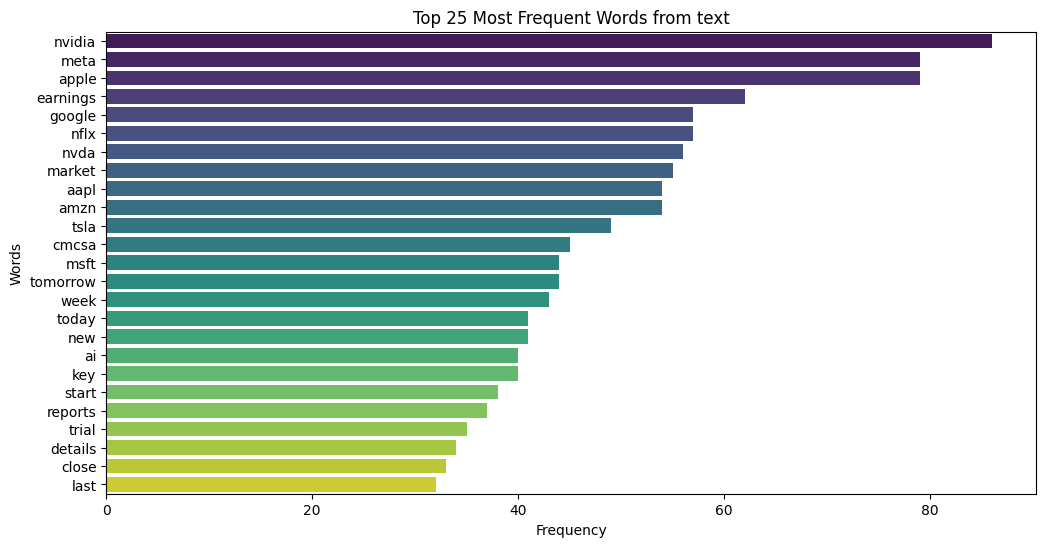

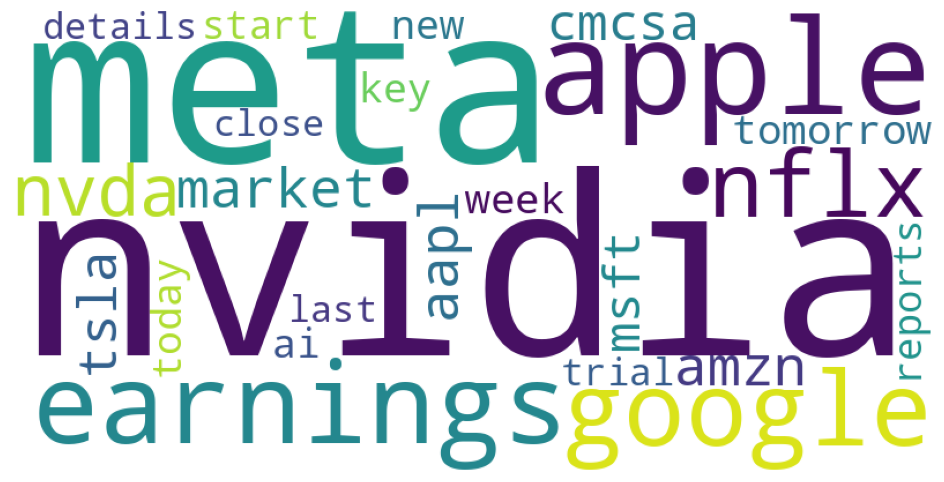

/tmp/ipykernel_9281/3537336777.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_counts.values, y=word_counts.index, palette='viridis')


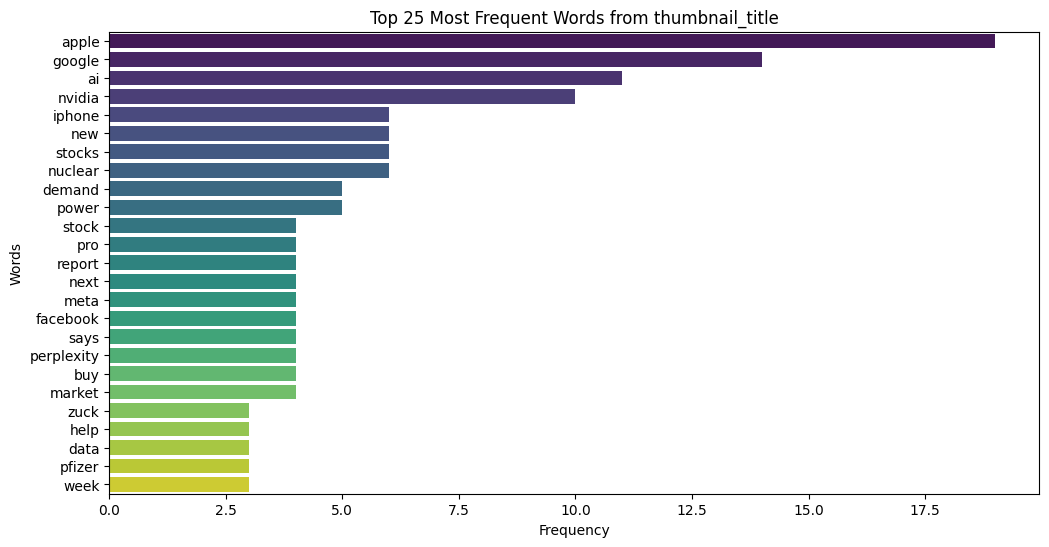

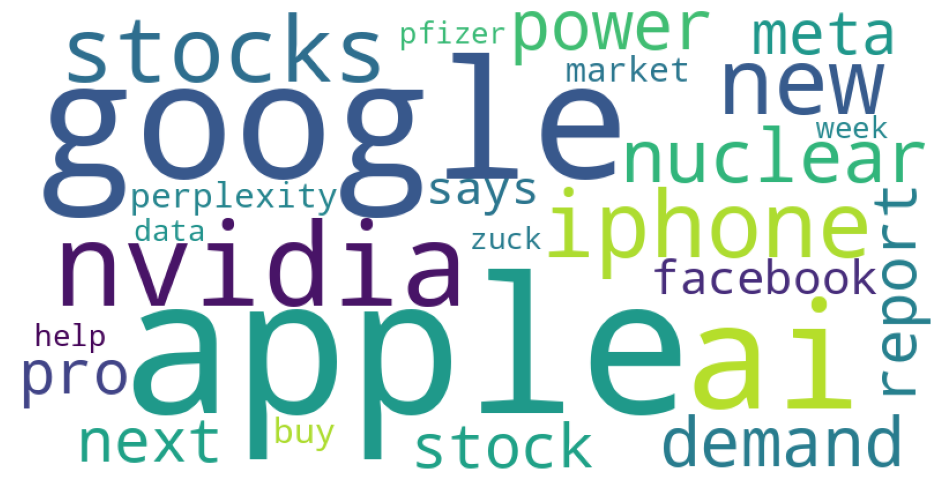

In [17]:
tw = TweetTokenizer()

special_symbols = ['“', '’', '”', '…', '...']
noise = stopwords.words("english") + list(punctuation) + special_symbols

def remove_stop_words(x):
    res = []
    for token in tw.tokenize(x.lower()):
        if token not in noise:
            res.append(token)
    return res

def process_text_att(data, col_name, top_count=25):
    word_counts = data[col_name].apply(remove_stop_words).explode().value_counts()[:top_count]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts.to_dict())
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=word_counts.values, y=word_counts.index, palette='viridis')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {top_count} Most Frequent Words from {data[col_name].name}')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
process_text_att(df, 'text')
process_text_att(df, 'thumbnail_title')

In [18]:
df['hashtags'].unique()

array(['[]', "['dividendstocks']", "['ElonMusk']", "['Sahm']",
       "['Lennar', 'Florida']", "['AI']", "['fridaynightdump']",
       "['Nike']", "['toosoon']", "['IBM', 'Earnings', 'Tech']",
       "['AI', 'StockMarket', 'investing']",
       "['Investing', 'DowJones', 'StockMarket']",
       "['StockMarket', 'FedRateCut', 'TechStocks']",
       "['Microsoft', 'Dividends', 'StockMarket']",
       "['NVIDIA', 'StockMarket', 'Investing']"], dtype=object)

Преобразуем список хештегов в формат строки

In [19]:
df['hashtags'] = df['hashtags'].apply(lambda x: ' '.join(eval(x)))

/tmp/ipykernel_9281/3537336777.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_counts.values, y=word_counts.index, palette='viridis')


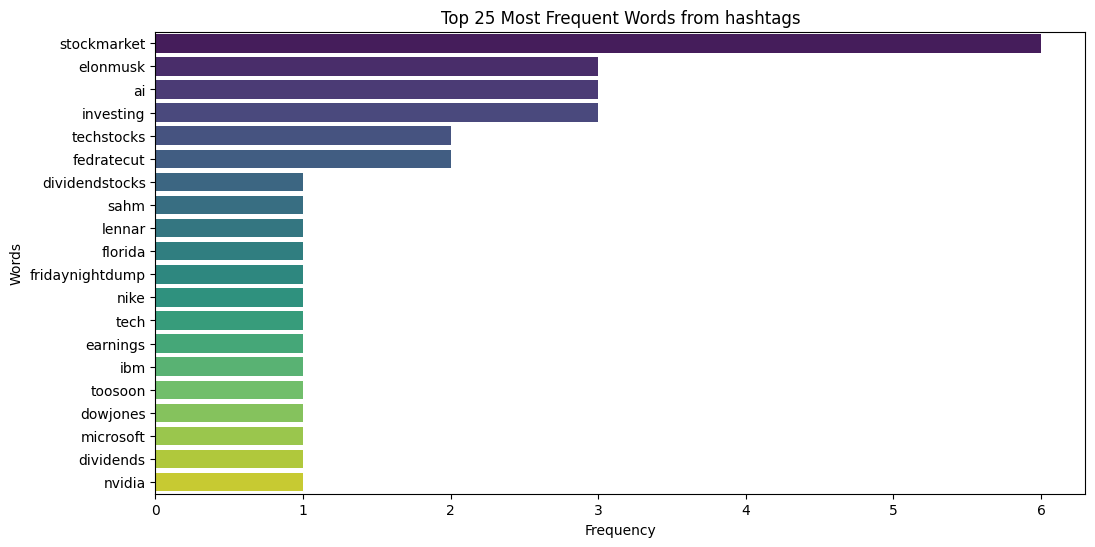

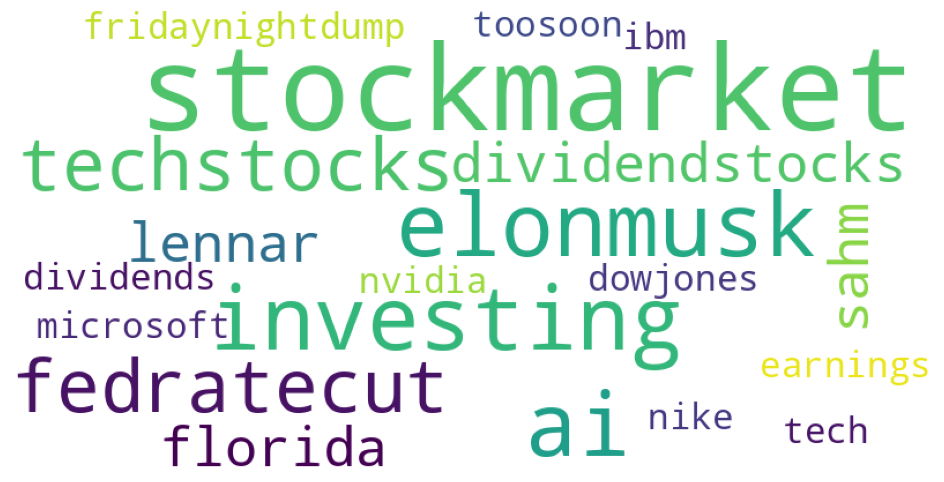

In [20]:
process_text_att(df, 'hashtags')

In [21]:
df[df['thumbnail_title'] == ''].shape

(452, 18)

In [22]:
df[df['hashtags'] == ''].shape

(510, 18)

In [23]:
df['text'] = df['text'] + ' ' + df['thumbnail_title'] + ' ' + df['hashtags']
df = df.drop(['thumbnail_title', 'hashtags'], axis=1)

### Тикеры самых упомянаемых компаний ###

/tmp/ipykernel_9281/265398946.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ticker_count.values, y=ticker_count.index, palette='viridis')


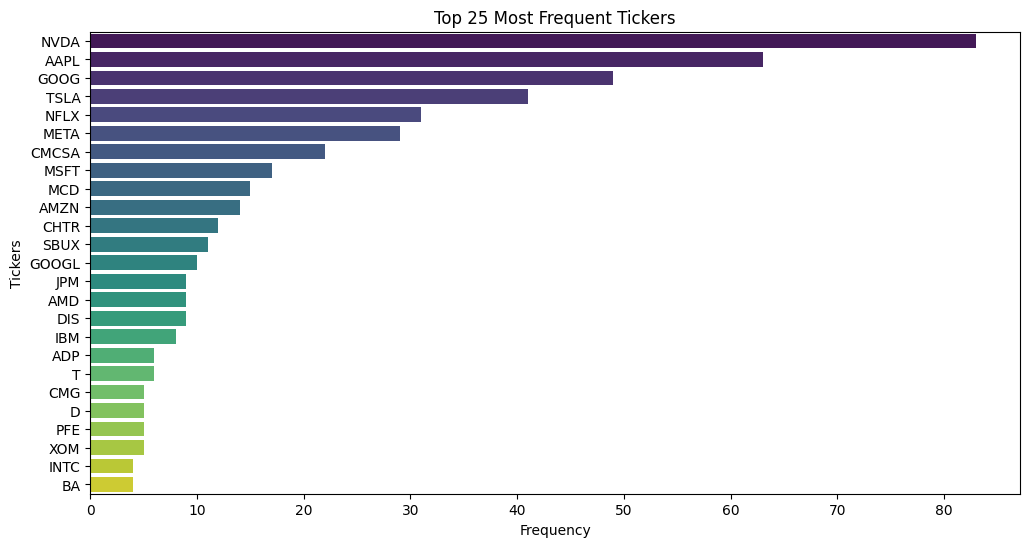

In [24]:
ticker_count = df['ticker'].value_counts()[:25]

plt.figure(figsize=(12, 6))
sns.barplot(x=ticker_count.values, y=ticker_count.index, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Tickers')
plt.title('Top 25 Most Frequent Tickers')
plt.show()

### date ###

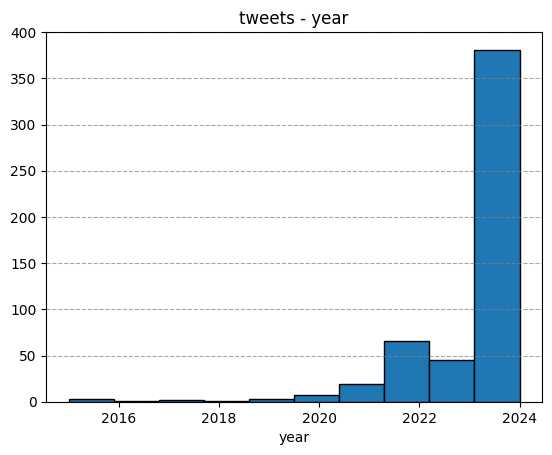

In [25]:
def create_hist(x, x_bins=None):  
    fig, ax = plt.subplots()
       
    ax.hist(x, edgecolor='black', bins=x_bins)    
      
    ax.grid(True, which='both', axis='y', linestyle='--', color='gray', alpha=0.7)    
    ax.set_xlabel(x.name)   
    ax.set_title(f'tweets - {x.name}')    
    plt.show()
    
create_hist(df['year'])

### text ###

Процент твитов с упомянанием нескольких компаний от общего кол-ва твитов:

In [26]:
(df.shape[0] - df['text'].unique().shape[0]) / df.shape[0]

0.23484848484848486

### lang ###

Уникальные значения:

In [27]:
df['lang'].unique()

array(['en', 'lv', 'sv', 'qct', 'es', 'fr', 'und', 'qme'], dtype=object)

In [28]:
for lang in df['lang'].unique():
    text_sample = df[df['lang'] == lang].iloc[0]['text']
    print(f'{lang = }: {text_sample}')

lang = 'en': The chance of $MSFT winning an  appeal of the negative ruling from the CMA are exceedingly slim. Per UBS, the Competition Appeal Tribunal that would hear an appeal has not ruled in favor of merging parties for years. Appeal could also take a year.Getting very close to "all dead". https://t.co/3bGHnuM1b7  
lang = 'lv': Tesla, $TSLA unveils "Robovan" https://t.co/2WipLfdtIE  
lang = 'sv': @asharoraa meta dinner!  
lang = 'qct': $GOOG  
lang = 'es': $NFLX slide - consolidation in Media Landscape https://t.co/wYOH2IWrqE  
lang = 'fr': Chart crime nomination - $T https://t.co/iNEK4e0dS6  
lang = 'und': $CMG 2016  
lang = 'qme': 🤔

$SBUX $CMG  


Кодировка языков официального API твитера https://developer.x.com/en/docs/x-for-websites/supported-languages не совпадает с кодировкой из библиотеки Twikit, с помощью которой были собранны данные.

В документации библиотеки Twikit, мне не удалось найти информации о кодировки языков, поэтому я решил убрать признак lang из дата сета, с учетом того, что судя по всему большинство данных сокращения не относятся к языкам или же они все-таки соответсвуют кодировки языков, но по неизвестной мне ошибке выводятся неккорректно. 

Далее примем, что все твиты написаны на английском языке. Это допущение можно сделать, поскольку данные собраны из англоязычных источников.

In [29]:
df = df.drop('lang', axis=1)

### in_reply_to ###

Заменем признак in_reply_to на признак is_in_reply_to, указывающий на тип твита, является он ответом на другой твит или нет: ответ (1), иначе (0). В целом, было бы полезно узнать информацию о твите, на который был отправлен ответ, но данный датасет такой информации в себе не хранит.

In [30]:
df['is_in_reply_to'] = df['in_reply_to'].fillna(0).apply(lambda x: 0 if x == 0 else 1)
df.drop('in_reply_to', axis=1, inplace=True)

### Обработка bool признаков ###

In [31]:
df.select_dtypes(include='bool').columns

Index(['is_quote_status', 'favorited', 'is_translatable', 'has_card'], dtype='object')

In [32]:
for col_name in df.columns:
    if df[col_name].dtypes == bool:
        df[col_name] = df[col_name].apply(int)

### favorited ###

In [33]:
df['favorited'].unique()

array([0])

In [34]:
df.drop('favorited', axis=1, inplace=True)

### _count признаки ###

view_count_state это категориальный признак, он показывает доступность получения информации о просмотренных твитах. Этот признак содержит только две категории, поэтому его можно перекодировать в бинарный - 1, если кол-во просмотров доступно; 0, если кол-во твитов недоступно.

In [35]:
df['is_view_count'] = df['view_count_state'].apply(lambda x: 1 if x == 'EnabledWithCount' else 0)
df = df.drop('view_count_state', axis=1)

Остальные _count признаки являеются численными.

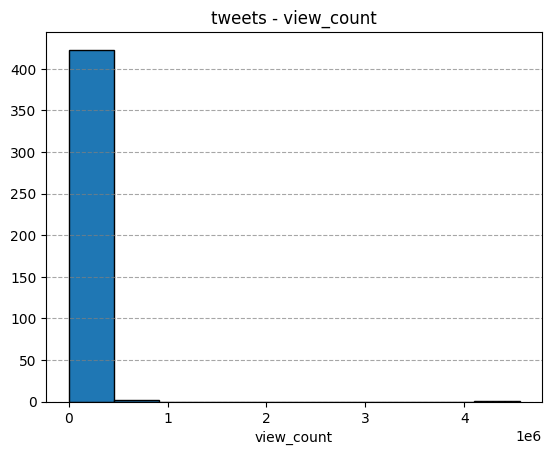

In [36]:
create_hist(df['view_count'])

Рассмотрим распределение данных без выбросов: 

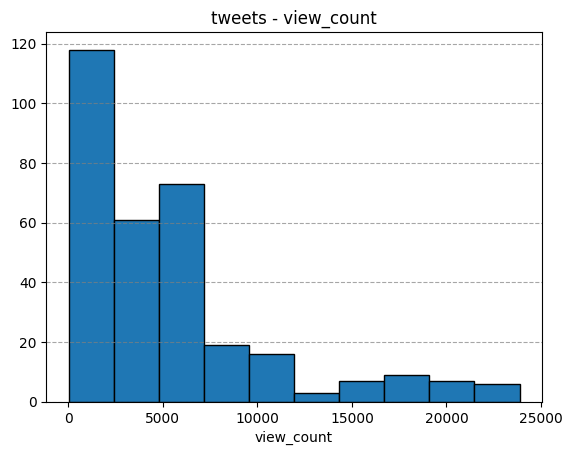

In [37]:
create_hist(df[df['view_count'] <= df['view_count'].quantile(0.75)]['view_count'])

### edits_remaining ###

In [38]:
df['edits_remaining'].unique()

array([ 5., nan])

Максимальное число оставшихся попыток равно 5.

In [39]:
df = df.drop('edits_remaining', axis=1)

### urls ###

Упростим этот признак до проверки наличия ссылок в твите.

In [40]:
df['urls'].unique()

array(['[]',
       "[{'display_url': 'spr.ly/6017UZthT', 'expanded_url': 'http://spr.ly/6017UZthT', 'url': 'https://t.co/LNuxk99HPs', 'indices': [134, 157]}]",
       "[{'display_url': 'unusualwhales.com/hottest-contra…', 'expanded_url': 'https://unusualwhales.com/hottest-contracts?limit=250&hide_index_etf=true&vol_greater_oi=true&max_multileg_volume_ratio=0.05&order=bid_ask_prem&order_direction=desc&min_premium=250000', 'url': 'https://t.co/bzo7DltDVW', 'indices': [142, 165]}]",
       "[{'display_url': 'unusualwhales.com/discord-bot', 'expanded_url': 'http://unusualwhales.com/discord-bot', 'url': 'https://t.co/lIDpnCxZai', 'indices': [140, 163]}]",
       "[{'display_url': 'unusualwhales.com/news/google-go…', 'expanded_url': 'https://unusualwhales.com/news/google-googl-goog-is-funding-the-construction-of-7-small-nuclear-power-reactors-in-the-us-to-help-with-energy-needed-for-ai', 'url': 'https://t.co/jrvaIL7g5U', 'indices': [114, 137]}]",
       "[{'display_url': 'trib.al/ok4s7jR', 

In [41]:
df['urls'] = df['urls'].apply(lambda x: 1 if x != '[]' else 0)

### Удаление признаков с одним значением ### 

In [42]:
for col_name in df.columns:
    if df[col_name].unique().shape[0] == 1:
        df = df.drop(col_name, axis=1)
        print(f'{col_name} deleted')

is_translatable deleted


### Добавление данных о котировках ###

In [43]:
qs0 = pd.read_csv('../../quotes/quotes.csv')
qs1 = pd.read_csv('../../quotes/quotes_08-11-2024.csv')
qs2 = pd.read_csv('../../quotes/quotes_08-11-2024_1.csv')

qs0 = qs0.drop(['Unnamed: 0', 'id'], axis=1).rename({'quote_date': 'date'}, axis=1)[qs1.columns]
qs = pd.concat([qs0, qs1, qs2])

qs['date'] = pd.to_datetime(qs['date'])
qs = qs.drop(['high', 'low', 'volume'], axis=1)
qs = qs.drop_duplicates().reset_index(drop='first')

qs.head()

,date,open,close,ticker
0,2024-10-18,236.18,235.00,AAPL
1,2024-10-17,233.43,232.15,AAPL
2,2024-10-16,231.60,231.78,AAPL
3,2024-10-15,233.61,233.85,AAPL
4,2024-10-14,228.70,231.30,AAPL


In [44]:

def open_price(X, Q):
    '''
    Возвращает модифицированный датасет X c новыми 
    аттрибутами quote_date и open, полученными из
    датасета с котировками Q.
    
    open - цена открытия в день публикации или в 
    первый доступный день до этой даты
    
    quote_date - дата котировки 
    '''
    def func(x):
        '''
        Возвращает котировку, соответвующую 
        дате и тикеру из x. Если такой котировки
        нет, возвращается значение None
        '''
        current_date = str(x['date'].date())
        ticker_name = x['ticker']
        filtered = Q[(Q['date'] <= current_date) & (Q['ticker'] == ticker_name)].sort_values(by='date', ascending=False)
        if filtered.empty:
            return None
        return filtered.iloc[0]
        
    buf = X.apply(func, axis=1).rename({'date': 'quote_date',
                                        'open': 'open_last'},
                                       axis=1).drop(['close', 'ticker'], axis=1)
    
    return pd.concat([X, buf], axis=1)

In [45]:
df = open_price(df, qs)

In [46]:
def close_price(X, Q, days = 1):
    '''
    Возвращает модифицированный датасет X c новым 
    аттрибутом close_{days}_day_after, полученными из
    датасета с котировками Q. Этот атрибут содержит цену закрытия
    через days дней после публикации твита (отсчитывается от даты 
    последней котировки).
    '''
    def func(x):
        '''
        Возвращает котировку, соответвующую дате
        через days дней после даты последней котировки и тикеру из x. 
        Если такой котировки нет, возвращается значение None
        '''
        current_date = x['quote_date'].date()
        ticker_name = x['ticker']
        next_date = current_date + pd.to_timedelta(days, unit='d')
        filtered = Q[(Q['date'] >= str(next_date)) & (Q['ticker'] == ticker_name)].sort_values(by='date')
        if filtered.empty:
            return None
        return filtered.iloc[0]
    
    buf = X.apply(func, axis=1).rename({'close': f'close_{days}_day_after'},
                                       axis=1).drop(['open', 'ticker', 'date'], axis=1)
    
    return pd.concat([X, buf], axis=1)

In [47]:
df = close_price(df, qs, 1)
# df = close_price(df, qs, 3)
# df = close_price(df, qs, 7)

In [48]:
df

,text,is_quote_status,date,view_count,has_card,urls,ticker,day,month,year,is_in_reply_to,is_view_count,quote_date,open_last,close_1_day_after
0,The chance of $MSFT winning an appeal of the ...,0,2023-04-26 12:23:58+00:00,113387.0,0,0,MSFT,26,4,2023,0,1,2023-04-26,296.700,304.83
1,We love and appreciate all the volunteers at t...,0,2024-05-06 13:54:43+00:00,707.0,0,0,NVDA,6,5,2024,0,1,2024-05-06,893.900,905.54
2,Today walking the lab on the NJ beach - tomorr...,0,2024-05-08 13:11:46+00:00,702.0,0,0,META,8,5,2024,0,1,2024-05-08,463.500,475.42
3,Today walking the lab on the NJ beach - tomorr...,0,2024-05-08 13:11:46+00:00,702.0,0,0,NVDA,8,5,2024,0,1,2024-05-08,894.825,887.47
4,Good Morning from a dog walk on the $NVDA resc...,0,2024-05-05 13:56:44+00:00,934.0,0,0,NVDA,5,5,2024,0,1,2024-05-03,877.890,921.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,Autonomy takes center stage in this quarter's ...,0,2024-10-25 21:04:57+00:00,6220.0,1,0,TSLA,25,10,2024,0,1,2024-10-25,256.010,262.51
524,Had to eat McDonalds over Wendy's this morning...,0,2024-09-23 14:04:14+00:00,18324.0,0,0,MCD,23,9,2024,0,1,2024-09-23,299.000,300.27
525,$BA big equity raise,0,2024-10-28 10:51:25+00:00,1021.0,0,0,BA,28,10,2024,0,1,2024-10-28,153.500,152.98
526,$JPM gives the BTC miners 9 months to get a de...,0,2024-10-24 13:17:26+00:00,1071.0,1,1,JPM,24,10,2024,0,1,2024-10-24,221.830,222.31


Проверка пропусков

In [49]:
df.isna().sum()

text                   0
is_quote_status        0
date                   0
view_count           102
has_card               0
urls                   0
ticker                 0
day                    0
month                  0
year                   0
is_in_reply_to         0
is_view_count          0
quote_date             0
open_last              0
close_1_day_after      1
dtype: int64

In [50]:
df['view_count'].fillna(df['view_count'].median(), inplace=True)

/tmp/ipykernel_9281/1370579765.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['view_count'].fillna(df['view_count'].median(), inplace=True)


In [51]:
df = df.dropna()
df = df.drop(['date', 'quote_date'], axis=1)

### Создание таргета ###

In [52]:
class СlsTargetTransformer(BaseEstimator, TransformerMixin):
    '''
    Класс трансформера, создающего таргет для задачи классификации.
    Положительная категория задается через процент минимальной прибыли.
    '''
    def __init__(self, shift_percent=0):
        """
        Инициализация трансформера с гиперпараметрами.
        :param shift_percent: Порог положительной категории таргета в процентах (опционально).
        """
        self.shift_percent = shift_percent

    def transform(self, X):
        """
        Метод transform: применяет преобразование к данным.
        :param X: Входные данные.
        :return: Преобразованные данные.
        """
        X_copy = X.copy()

        # for k in [1, 3, 7]:
        for k in [1]:
            col_name = f'{k}_day_after'
            X_copy[col_name] = (X_copy[f'close_{k}_day_after'] / X_copy['open_last'] - 1) * 100 - self.shift_percent
            X_copy[col_name] = X_copy[col_name].apply(lambda x: 1 if x >= 0 else 0)

        # X_copy = X_copy.drop(['close_1_day_after', 'close_3_day_after', 'close_7_day_after', 'open_last'], axis=1)
        X_copy = X_copy.drop(['close_1_day_after', 'open_last'], axis=1)

        return X_copy

In [53]:
class_target_transformer = СlsTargetTransformer()

df0 = class_target_transformer.transform(df)

df0.head()

,text,is_quote_status,view_count,has_card,urls,ticker,day,month,year,is_in_reply_to,is_view_count,1_day_after
0,The chance of $MSFT winning an appeal of the ...,0,113387.0,0,0,MSFT,26,4,2023,0,1,1
1,We love and appreciate all the volunteers at t...,0,707.0,0,0,NVDA,6,5,2024,0,1,1
2,Today walking the lab on the NJ beach - tomorr...,0,702.0,0,0,META,8,5,2024,0,1,1
3,Today walking the lab on the NJ beach - tomorr...,0,702.0,0,0,NVDA,8,5,2024,0,1,0
4,Good Morning from a dog walk on the $NVDA resc...,0,934.0,0,0,NVDA,5,5,2024,0,1,1


In [54]:
target_cols = ['1_day_after']

for col in target_cols:
    buf = df0[col].value_counts(normalize=True)
    print(buf.to_frame())
    print('-' * 25)

             proportion
1_day_after            
1              0.531309
0              0.468691
-------------------------


In [55]:
df0 = df0.drop('ticker', axis=1)

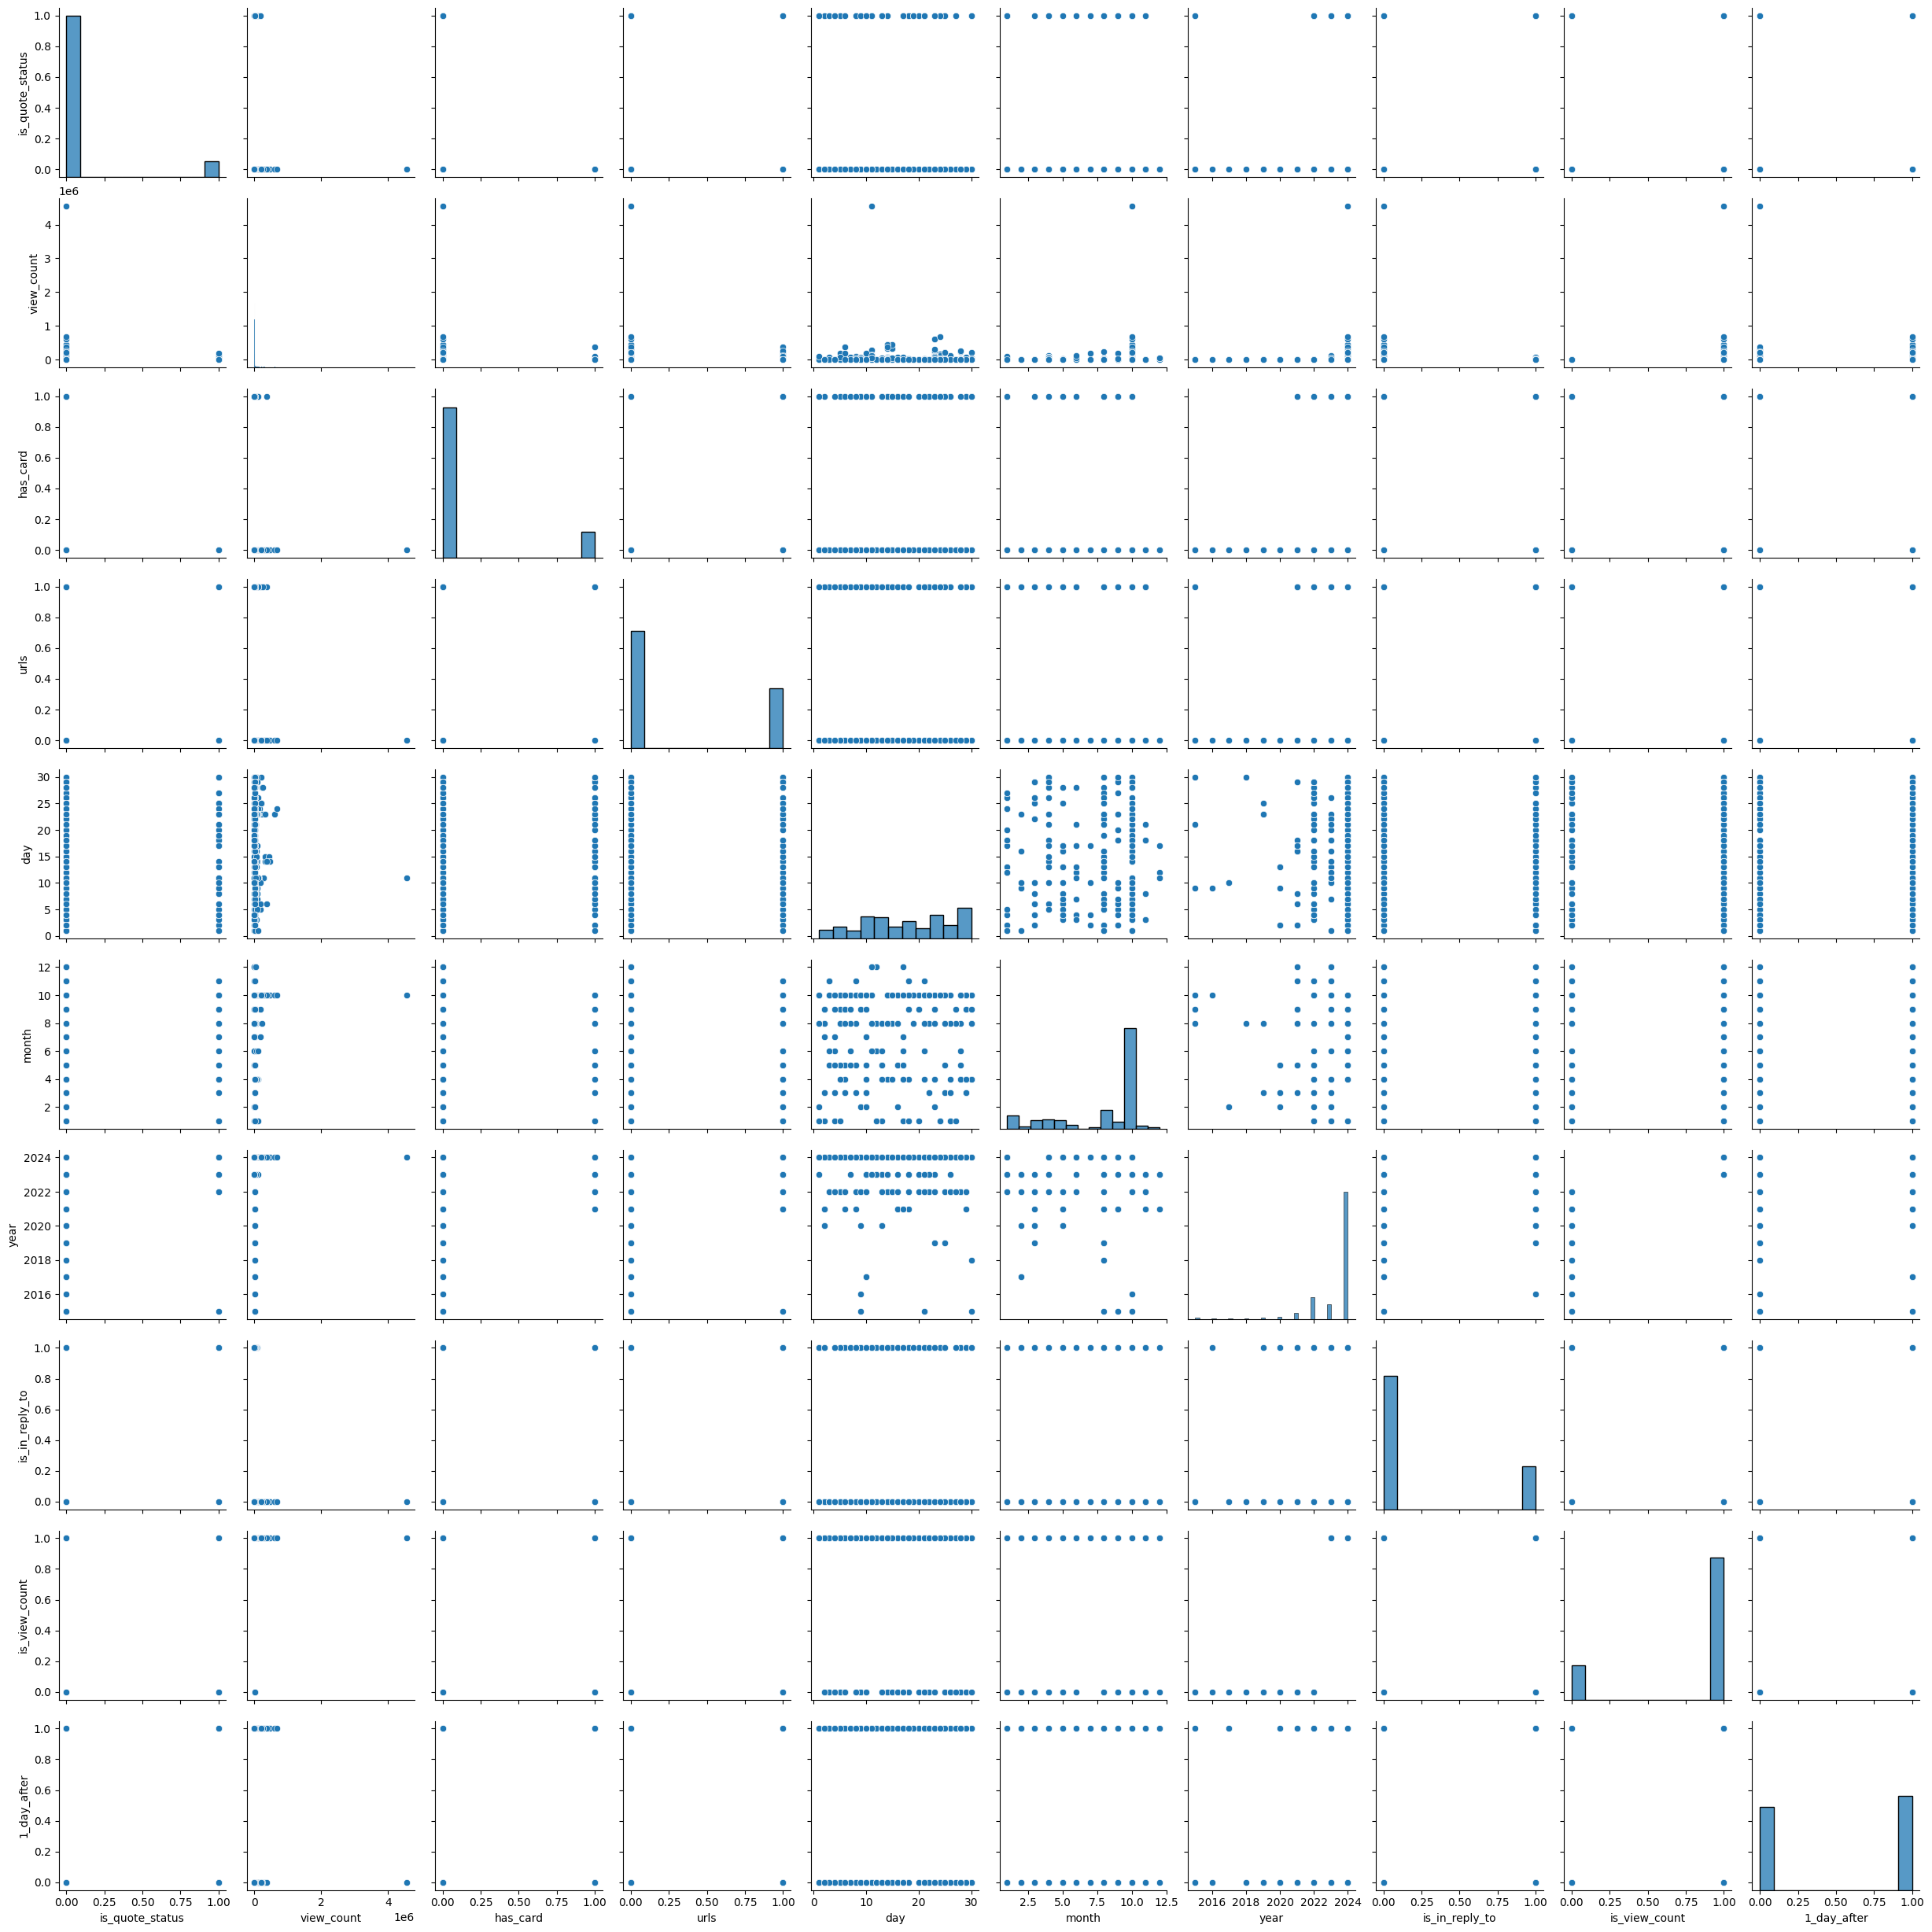

In [56]:
sns.pairplot(df0)

In [57]:
df0_corr = df0.select_dtypes(include='number').corr()
df0_corr

,is_quote_status,view_count,has_card,urls,day,month,year,is_in_reply_to,is_view_count,1_day_after
is_quote_status,1.000000,-0.036747,-0.128893,-0.191448,-0.093742,0.010701,0.030779,-0.113516,0.032386,0.007541
view_count,-0.036747,1.000000,-0.035659,-0.059316,-0.031578,0.092157,0.076977,-0.089762,0.078446,-0.017405
has_card,-0.128893,-0.035659,1.000000,0.574786,0.032426,0.079975,0.131498,-0.075724,0.123036,0.038098
urls,-0.191448,-0.059316,0.574786,1.000000,0.166683,0.214516,0.210753,-0.208628,0.216182,0.007715
day,-0.093742,-0.031578,0.032426,0.166683,1.000000,0.122123,0.093639,-0.126545,0.073962,-0.075659
month,0.010701,0.092157,0.079975,0.214516,0.122123,1.000000,0.353673,-0.285966,0.355198,0.108945
year,0.030779,0.076977,0.131498,0.210753,0.093639,0.353673,1.000000,-0.181578,0.819162,0.152554
is_in_reply_to,-0.113516,-0.089762,-0.075724,-0.208628,-0.126545,-0.285966,-0.181578,1.000000,-0.201433,-0.040142
is_view_count,0.032386,0.078446,0.123036,0.216182,0.073962,0.355198,0.819162,-0.201433,1.000000,0.175108
1_day_after,0.007541,-0.017405,0.038098,0.007715,-0.075659,0.108945,0.152554,-0.040142,0.175108,1.000000


<Axes: >

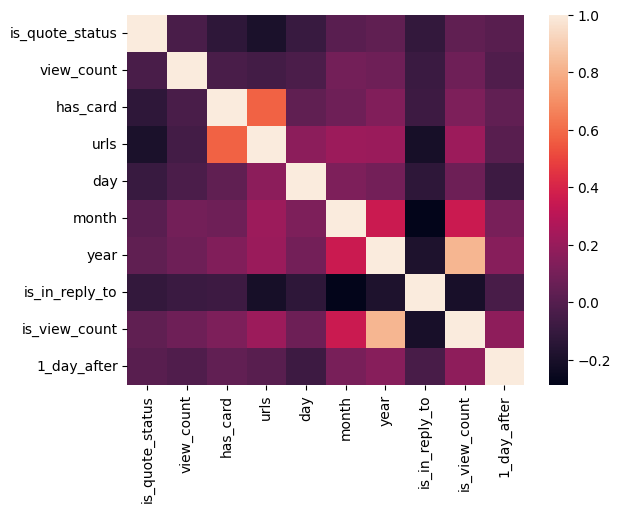

In [58]:
sns.heatmap(df0_corr)

In [59]:
df0.to_csv('../tweets.csv')

### Выводы ###

- Размеченный датасет получился слишком мальнький для обучения модели только на данных из твиттера. В текущем состоянии его можно использовать в качестве дополнительных данных для более объемной модели.
- Проблема малого кол-ва объектов в дата сете связана в первую очередь с не самым оптимальным подходом для сбора данных из твитера. Так же это связано с недостатком наименований компаний на этапе выявления тикеров из уже собранных твитов.

### Что можно исправить? ###

- Оптимизировать парсер
- Добавить больше наименований компаний